## Stability of a shallow arch under a point load

In [1]:
# load libraries

from ansys.mapdl.core import launch_mapdl
import numpy as np
import matplotlib.pyplot as plt

# function to plot deformed shape
def plot_Deformation(x_N,y_N,ux,uy):
    # --- Settings ---
    scale = 1  # deformation magnification

    # --- Undeformed coordinates ---
    x_orig = x_N
    y_orig = y_N

    # --- Deformed coordinates ---
    x_def = x_orig + scale * ux
    y_def = y_orig + scale * uy

    # --- Plot ---
    plt.figure(figsize=(10, 4))

    # Plot undeformed shape
    plt.plot(x_orig, y_orig, 'k--', linewidth=1)

    # Plot deformed shape
    plt.plot(
        x_def, y_def,
        '-o',
        markerfacecolor = "yellow",
        markeredgecolor = "blue",
        color = "blue",
        markersize = 6
    )

    # --- Final layout ---
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("deformed shape")
    plt.tight_layout()
    plt.grid()
    plt.show()

def plot_LDC(x,y):

    # plot load-displacement curve
    plt.plot(x, y,
            '-o',
            color = 'blue', 
            linewidth = 2 ,
            markerfacecolor = 'yellow',
            markeredgecolor = 'b',
            markersize = 6
        )
    plt.grid()
    # Labels
    plt.xlabel("u")
    plt.ylabel(r"$\lambda$")
    # title
    plt.title('load-displacement-curve')

    plt.show()

### Properties of arch

Shallow arch under vertical point load

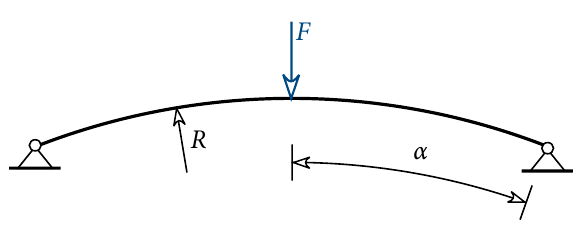

In [2]:
R = 40              # radius in m
alpha = 20          # half of open angle in °
n_El = 30           # number of elements
Fref = -100E3       # magnitude of vertical force at top in N

Ex = 2.1E11         # Youngs modulus
nu = 0.3            # Poisson ratio

b = 0.05            # width in m
h = 0.20            # heigth in m 

### Discretization
Generate ANSYS input file

In [3]:
# MAPDL starten
mapdl = launch_mapdl(nproc=1)

# Start mapdl and clear it.
mapdl.clear()
mapdl.verify()

# Enter verification example mode and the pre-processing routine.
mapdl.prep7()

# Element type: BEAM188.
mapdl.et(1, "188")
# 2D analysis (uy, ux and rotz)
# *** element y axis coincide with global -Z axis ***
mapdl.keyopt(1, 5, 1)   

# Material type: linear elastic
mapdl.mp("EX", 1, Ex)               # Youngs modulus N/m^2
mapdl.mp("PRXY", 1, nu)             # Poisson ratio

# cross section of beam
mapdl.sectype(1, "Beam", "RECT", "my_sec")  # rectangular cross section
mapdl.secdata(b, h)                         # b (in element y) and h (in element z) in m

# Define nodes
x_N = R*np.sin(np.linspace(np.deg2rad(-alpha), np.deg2rad(alpha), n_El + 1))
y_N = R*np.cos(np.linspace(np.deg2rad(-alpha), np.deg2rad(alpha), n_El + 1))
for i in range(1, n_El+2):
    mapdl.n(i, x_N[i-1], y_N[i-1], 0)

# Define elements
for i in range(1, n_El+1):  
    mapdl.e(i, i+1)

# BC for the beams seats
mapdl.d(1, "UX")
mapdl.d(1, "UY")
mapdl.d(n_El+1, "UY")
mapdl.d(n_El+1, "UX")

# Load at top
mapdl.f(n_El/2+1, "FY", Fref)


SPECIFIED NODAL LOAD FY   FOR SELECTED NODES        16 TO       16 BY        1
  REAL= -100000.000       IMAG=  0.00000000

### Geometric Static Nonlinear Analysis
The geometric nonlinear response of the arch is computed, till the reference force

In [4]:
numSubSteps = 10                # number of increments

mapdl.run("/solu")

mapdl.autots("off")             # automatic time stepping off
mapdl.antype("static")          # static analysis
mapdl.nlgeom("on")              # activate geometric nonlinearities
mapdl.nsubst(numSubSteps)       # number of increments (substeps)
mapdl.outres("basic","all")     # store basic results at any increment

out = mapdl.solve()             # solve
mapdl.finish()

FINISH SOLUTION PROCESSING


 ***** ROUTINE COMPLETED *****  CP =         0.000

#### Post processing

*****  INDEX OF DATA SETS ON RESULTS FILE  *****

     SET   TIME/FREQ    LOAD STEP   SUBSTEP  CUMULATIVE
       1 0.10000000             1         1         2                  
       2 0.20000000             1         2         4                  
       3 0.30000000             1         3         6                  
       4 0.40000000             1         4         8                  
       5 0.50000000             1         5        10                  
       6 0.60000000             1         6        12                  
       7 0.70000000             1         7        14                  
       8 0.80000000             1         8        16                  
       9 0.90000000             1         9        18                  
      10  1.0000000             1        10        20


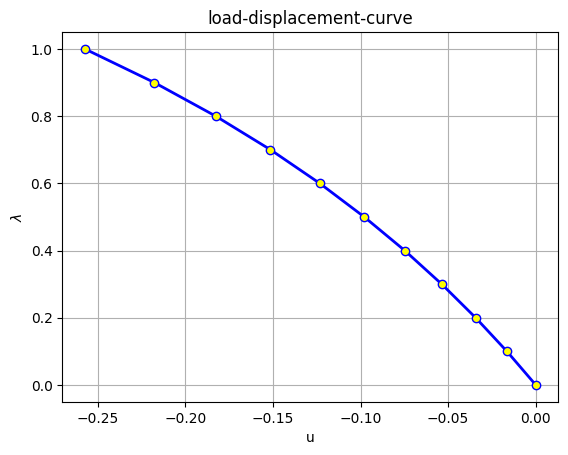

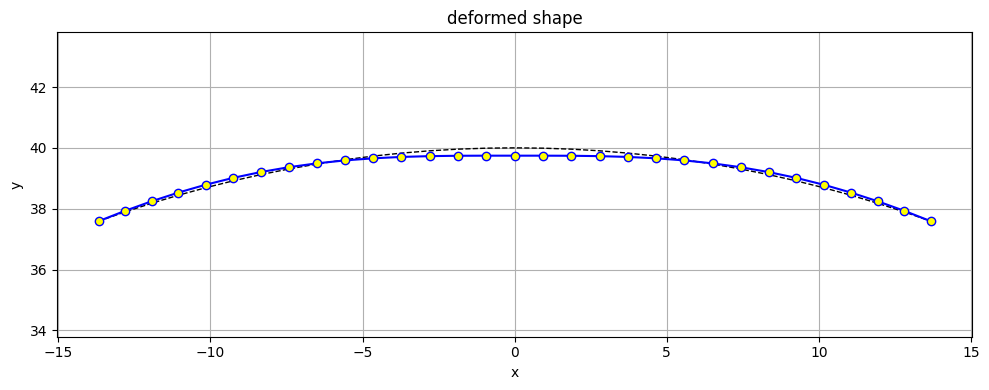

EXIT THE MAPDL POST1 DATABASE PROCESSOR


 ***** ROUTINE COMPLETED *****  CP =         0.000

In [5]:
# Enter the post-processing routine and select the first load step.
mapdl.post1()

# print all load cases and substeps
output = mapdl.set("LIST")
print(output)

# monitor DOF
u_monitor_0 = np.zeros((numSubSteps+1,2))
# get displacement and load factor of monitor DOF
for i in range(1,numSubSteps+1):
    mapdl.set(1, i)
    u_monitor_0[i,0] = mapdl.get_value(entity="NODE", entnum=n_El/2+1, item1="u", it1num="y")
    u_monitor_0[i,1] = mapdl.get_value(entity="ACTIVE", entnum=0, item1="set", it1num="time")

# plot load-displacement curve
plot_LDC(u_monitor_0[:,0], u_monitor_0[:,1])

# Get nodal displacements
ux = np.zeros(n_El+1)
uy = np.zeros(n_El+1)
for i in range(0, n_El+1):
    ux[i] = mapdl.get_value(entity="NODE", entnum=i+1, item1="u", it1num="x")
    uy[i] = mapdl.get_value(entity="NODE", entnum=i+1, item1="u", it1num="y")

# plot deformed shape
plot_Deformation(x_N, y_N, ux, uy)

mapdl.finish()

### Linear Buckling Analysis

In [6]:
mapdl.run("/solu")
mapdl.antype(status="restart", action="perturb")                            # restart analysis from before
mapdl.perturb(type_="buckle", contkey="current", loadcontrol="allkeep")     # keep all forces
mapdl.solve("elform")                                                       # assemble matrices at the last load level

mapdl.bucopt(method="subsp", nmode="3") # use subspace an extract 3 buckling modes
mapdl.outres(item="basic",freq="all")   # save basic output

mapdl.mxpand(nmode="all",elcalc="yes")  # expand all modes

out = mapdl.solve()
mapdl.finish()

# *** set geometry to perfect ***
mapdl.prep7()
for i in range(1, n_El+2):
    mapdl.nmodif(i, x_N[i-1], y_N[i-1])

#### Read and plot buckling mode

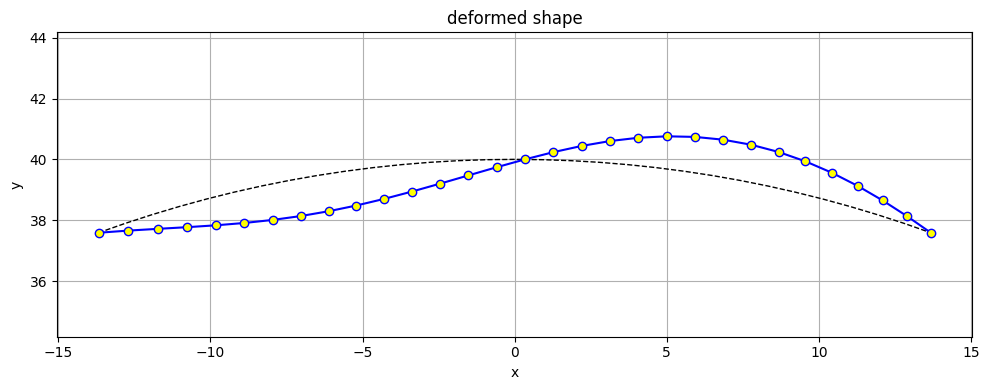

F_c= -152592.95


In [7]:
# read binary mode file for buckling modes and load scaling factor
xpl = mapdl.xpl
xpl.open('file.mode')
#print(xpl.list())
buckModes = xpl.read("SHP","True")
#print(buckModes)
scal_load = xpl.read("FRQ","True")
#print(scal_load)

# Get nodal displacements
ux = np.zeros(n_El+1)
uy = np.zeros(n_El+1)

# number of buckling mode
numMode = 0
# scaling for plotting
scal = 500
ux = scal*buckModes[0::3,numMode]
uy = scal*buckModes[1::3,numMode]

# plot buckling mode
plot_Deformation(x_N, y_N, ux, uy)

# critical load
F_crit = Fref*(1+scal_load[0])
print(f"F_c= {F_crit:.2f}")

### Geometric Nonlinear Analysis of Perfect and Imperfect Arch

#### Perfect arch
Use the arc-length method to determine the response of the perfect arch. 

In [8]:
mapdl.prep7()

mapdl.f(n_El/2+1, "FY", -160E3)     # change the reference load

mapdl.run("/solu")

mapdl.antype("static")

mapdl.nlgeom("on")      # geometric nonlinear analysis

mapdl.arclen("on")                          # activate arc-length method 
mapdl.arctrm("u", "4.0", n_El/2+1, "uy")    # terminate analysis when monitor DOF reach limit

mapdl.outres("basic","all")     # save all basic output

mapdl.solve()

mapdl.finish()

FINISH SOLUTION PROCESSING


 ***** ROUTINE COMPLETED *****  CP =         0.000

##### Post-Processing

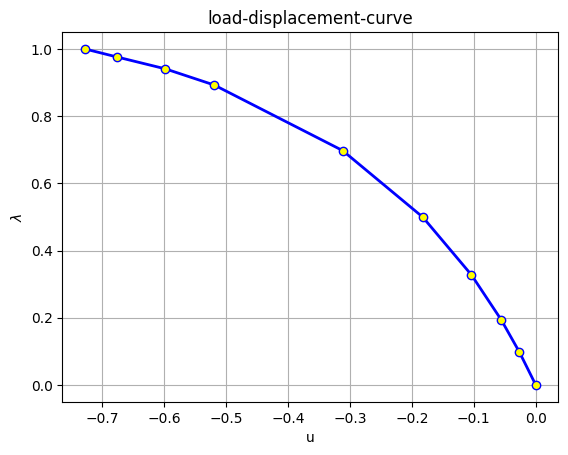

In [9]:
mapdl.post1()

out = mapdl.set("list")
#print(out)

# monitor DOF
m = int(mapdl.get_value(entity="ACTIVE", entnum=0, item1="set", it1num="sbst"))                 # number of increments in the arc-length method
u_monitor_0 = np.zeros((m+1,2))
# get displacement and load factor of monitor DOF
for i in range(1,m+1):
    mapdl.set(1, i)
    u_monitor_0[i,0] = mapdl.get_value(entity="NODE", entnum=n_El/2+1, item1="u", it1num="y")
    u_monitor_0[i,1] = mapdl.get_value(entity="ACTIVE", entnum=0, item1="set", it1num="time")

# plot load displacement curve
plot_LDC(u_monitor_0[:,0], u_monitor_0[:,1])

#### Imperfect arch
Apply geometric imperfections in the shape of the first buckling mode.

In [10]:
phi = buckModes[:,0]/(np.max(np.abs(buckModes[:,0])))   # scale buckling mode that largest entry is 1

# magnitude of imperfection
scal = 0.001
# imperfection
imp  = scal*phi

mapdl.prep7()

# apply imperfection to perfect arch
for i in range(1, n_El+2):
    mapdl.nmodif(i, x_N[i-1] + imp[(i-1)*3], y_N[i-1] + imp[(i-1)*3+1],0)

# solve
mapdl.run("/solu")

mapdl.antype("static")

mapdl.nlgeom("on")

mapdl.arclen("on")
mapdl.arctrm("u", "4.0", n_El/2+1, "uy")

mapdl.outres("basic","all")

mapdl.solve()

mapdl.finish()


##### Post-Processing

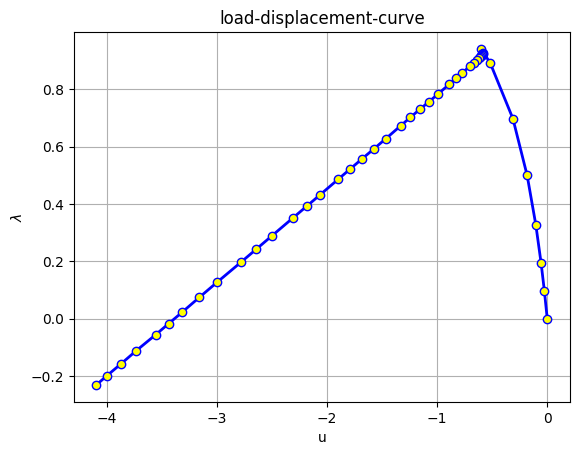

In [11]:
mapdl.post1()

# monitor DOF
m = int(mapdl.get_value(entity="ACTIVE", entnum=0, item1="set", it1num="sbst"))                 # number of increments in the arc-length method
u_monitor_0 = np.zeros((m+1,2))
for i in range(1,m+1):
    mapdl.set(1, i)
    u_monitor_0[i,0] = mapdl.get_value(entity="NODE", entnum=n_El/2+1, item1="u", it1num="y")
    u_monitor_0[i,1] = mapdl.get_value(entity="ACTIVE", entnum=0, item1="set", it1num="time")

# plot load displacement curve
plot_LDC(u_monitor_0[:,0], u_monitor_0[:,1])


In [12]:
mapdl.exit()